In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Step 1: Load the dataset
data = pd.read_csv('merged_TimeWVHT_data.csv')
print(data.head())  # Display the first few rows to understand the structure

# Assuming the dataset has a 'Date' column and a 'Value' column
data['Date'] = pd.to_datetime(data['DD'])
data.set_index('Date', inplace=True)

      #YY   MM   DD       ATMP       WTMP      WVHT
0  2020.0  1.0  1.0  26.772222  28.212500  1.245833
1  2020.0  1.0  2.0  27.189928  28.054167  1.108333
2  2020.0  1.0  3.0  26.284722  27.933333  1.212500
3  2020.0  1.0  4.0  26.873611  27.754167  1.291667
4  2020.0  1.0  5.0  25.072222  27.808333  1.233333


In [5]:
# Step 2: Preprocess the data
# Extract the target variable
values = data['WVHT'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Convert to supervised learning format
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10  # Number of past time steps to consider
X, y = create_sequences(scaled_values, time_steps)

# Reshape X to be [samples, time_steps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [6]:
# Step 3: Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# Step 4: Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Step 5: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0613 - val_loss: 0.0107
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0083
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_lo

In [9]:
# Step 6: Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


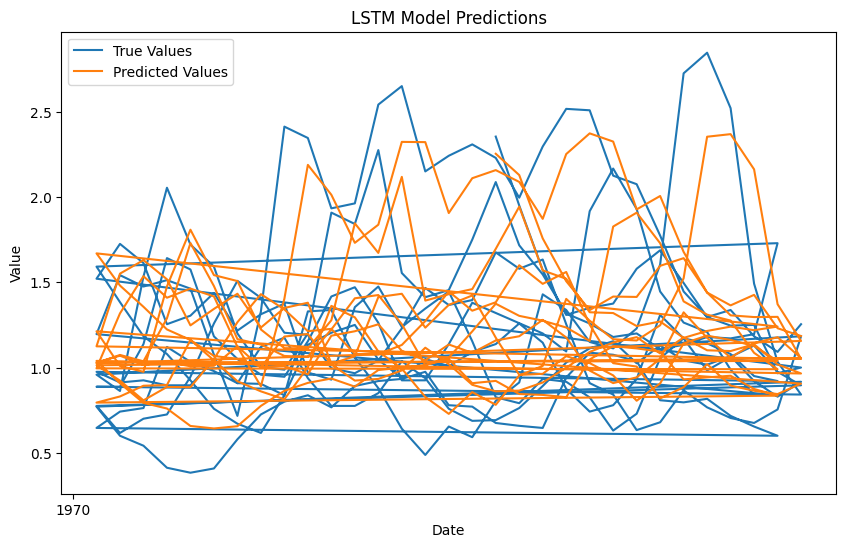

In [10]:
# Step 7: Visualize results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='True Values')
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LSTM Model Predictions')
plt.legend()
plt.show()